In [157]:
# import libraries and packages 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn import model_selection, linear_model, metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedShuffleSplit, KFold
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb
import seaborn as sns

In [158]:
# load csv dataset using pandas dataframe
df = pd.read_csv("credit_risk_dataset.csv")

In [159]:
# display info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [160]:
df.shape

(32581, 12)

"""
Person age: tuổi hiện tại                                       
Person income: thu nhập hàng năm tại thời điểm cho vay (income/year)                       
Person home ownership: loại hình sỡ hữu nhà (nơi đang sống hiện tại)                      
Person employment length: thời gian làm việc (tính theo năm)                             
Loan intent: mục đích vay                                                              
Loan amount: số tiền vay / khoản vay                                           
Loan interest rate: tỉ lệ lãi suất cho vay                                              
loan percent income: tiền vay / thu nhập.                                          
cb person default on file: trước đó đã từng vỡ nợ hay chưa.                                      
cb person cred hist length: khoản vay trước đó cách khoản vay hiện tại bao nhiêu năm
"""

In [6]:
# some basic statistic of dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


Từ bảng thống kê trên ta thấy một số điểm vô lý

-độ tuổi lớn nhất là 144 => outlier

-thời gian làm việc 123 => outlier

In [7]:
# Calculate null per features.
NaN = df.isnull().sum()
NaN

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Hai giá trị tồn tại null/NaN là person_emp_length vaf loan_int_rate

Dựa vào biểu đồ ta có thể thấy độ tuổi cũng những người trong dataset nằm phần lớn trong khoảng từ 20 đến 60 tuổi, 1 phần nhỏ từ 60->80    
Loại bỏ những outlier về độ có độ tuổi > 90 và có số năm làm việc <20.   
Loại bỏ những outlier có > 120 năm kinh nghiệm nhưng độ tuổi chỉ ở 20

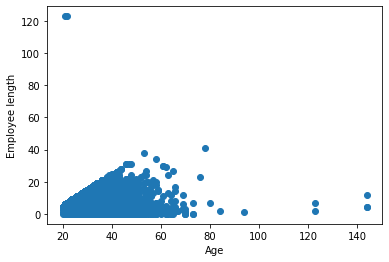

In [8]:
plt.scatter("person_age", 'person_emp_length', data=df)
plt.xlabel('Age')
plt.ylabel('Employee length')
plt.show()

In [9]:
df = df[df["person_age"] < 90]
df = df[df["person_emp_length"] < 120]

Biểu đồ cho ta thấy được loan_grade được đánh giá tương quan với giá trị loan interest rate.

<AxesSubplot:xlabel='person_age', ylabel='loan_int_rate'>

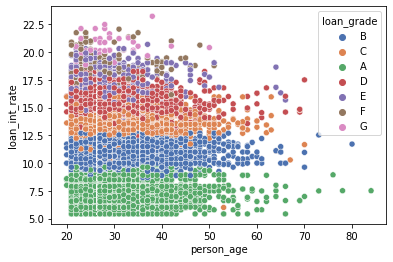

In [10]:
sns.scatterplot(data=df, x="person_age", y="loan_int_rate", hue="loan_grade", palette="deep")

In [11]:
Split data: original
train - validation - test => constrain 
kfold validation = 35000 => 5 tap nho => A B C D E

Logistic Regression, Decision Tree (Random Forest), SVM, Neural Network, Kmean.

GridSearch, RandomizedSearch

Metrics:
Accuracy
Confusion Matrix
Precision/Recall
F1 Score / Average Precision / AUC 

SyntaxError: invalid syntax (405203203.py, line 1)

In [162]:
features = df.drop(columns=["loan_status"], axis=1)
labels = df["loan_status"]

In [163]:
features.shape, labels.shape

((32581, 11), (32581,))

In [12]:
# calculate percentage per class in entire dataset
df[df["loan_status"] == 1].shape[0] / len(df), df[df["loan_status"] == 0].shape[0] / len(df)

(0.21544920765199824, 0.7845507923480017)

In [13]:
columns = ["person_age", "person_emp_length", "person_income"]
df[columns].quantile()

person_age              26.0
person_emp_length        4.0
person_income        56000.0
Name: 0.5, dtype: float64

In [14]:
df.select_dtypes("object")

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y
5,OWN,VENTURE,A,N
...,...,...,...,...
32576,MORTGAGE,PERSONAL,C,N
32577,MORTGAGE,PERSONAL,A,N
32578,RENT,HOMEIMPROVEMENT,B,N
32579,MORTGAGE,PERSONAL,B,N


In [140]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns, factor=1.5):
        self.columns = columns
        self.factor = factor
        
    def outliers_iqr(self, X, y=None):
        # filter only those rows that are greater than lower_bound and less than upper_bound, 
        #i.e. drop values outside the given interval
        # filter only columns has name in self.columns
        for col in self.columns:
            X = X.loc[(X[col] >= self.lower_bound[col]) & (X[col] <= self.upper_bound[col])]
#         X = X.loc[(X >= self.lower_bound) & (X <= self.upper_bound)]
        return X
    
    def fit(self, X, y=None):
        if self.columns:
            q1 = X[self.columns].quantile(0.25)
            q3 = X[self.columns].quantile(0.75)
            iqr = q3 - q1
            self.lower_bound = q1 - (iqr * self.factor)
            self.upper_bound = q3 + (iqr * self.factor)
        
        return self
    
    def transform(self, X):
        if self.columns:
            X[self.columns] = self.outliers_iqr(X[self.columns])
        return X

In [186]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
    
    def fit(self, X, y=None):
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (iqr * self.factor)
        self.upper_bound = q3 + (iqr * self.factor)
        
        return self
    
    def transform(self, X, y=None):
        return X.loc[(X >= self.lower_bound) & (X <= self.upper_bound)]

In [191]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        
    def outliers_iqr(self, X, y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (iqr * self.factor)
        upper_bound = q3 + (iqr * self.factor)
        # filter only those rows that are greater than lower_bound and less than upper_bound, 
        #i.e. drop values outside the given interval
        X.loc[((X >= lower_bound) | (X <= upper_bound))] 
        
        return pd.Series(X)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.outliers_iqr)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

Outlier Remover references from: https://stackoverflow.com/questions/67900695/create-a-custom-transformer-that-removes-outliers-in-python               
And custom Transformer Sklearn from: https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [192]:
abc = OutlierRemover()

In [199]:
likely_to_have_outlier = ["person_age","person_income","person_emp_length","cb_person_cred_hist_length"]

In [196]:
preprocessor = ColumnTransformer([
        ("outlier_removal", abc, likely_to_have_outlier),
])

In [197]:
preprocessing.fit(features)

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [129]:
pipe.fit(features)

Pipeline(steps=[('remove_outlier',
                 OutlierRemover(columns=['person_age', 'person_emp_length']))])

In [130]:
f = pipe.transform(features)

       person_age  person_emp_length
0            22.0                NaN
1            21.0                5.0
2            25.0                1.0
3            23.0                4.0
4            24.0                8.0
...           ...                ...
32576         NaN                1.0
32577         NaN                4.0
32578         NaN                3.0
32579         NaN                5.0
32580         NaN                2.0

[32581 rows x 2 columns]


In [132]:
likely_to_have_outlier = ["person_age","person_income","person_emp_length","cb_person_cred_hist_length"]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,NaN,59000,RENT,NaN,PERSONAL,D,35000,16.02,0.59,Y,3
1,21.0,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
2,25.0,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3
3,23.0,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2
4,24.0,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
32576,NaN,53000,MORTGAGE,NaN,PERSONAL,C,5800,13.16,0.11,N,30
32577,NaN,120000,MORTGAGE,NaN,PERSONAL,A,17625,7.49,0.15,N,19
32578,NaN,76000,RENT,NaN,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28
32579,NaN,150000,MORTGAGE,NaN,PERSONAL,B,15000,11.48,0.10,N,26


In [148]:
pipe = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("encoder", OneHotEncoder()),
    ("imputer", SimpleImputer()),
    ("std_scaler", StandardScaler()),
])

In [149]:
pipe.fit(features)

TypeError: zip argument #2 must support iteration

In [22]:
features = pipe.transform(features)

In [23]:
features

array([[-1.08659218, -1.73401195,  0.22471587, ..., -0.65516975,
        -0.46480756, -0.93853532],
       [-0.4404905 , -1.73401195, -1.16889207, ...,  3.76904612,
        -0.46480756, -0.6921063 ],
       [-0.76354134,  0.38244132,  0.92151984, ...,  3.39251711,
        -0.46480756, -0.93853532],
       ...,
       [ 6.0205263 ,  0.72745708,  0.92151984, ...,  2.73359134,
        -0.46480756,  5.46861918],
       [ 4.56679752,  1.65463121, -1.16889207, ..., -0.65516975,
        -0.46480756,  4.97576114],
       [ 6.18205172, -0.71590342,  0.92151984, ..., -0.18450849,
        -0.46480756,  5.96147722]])

In [24]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [25]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred = clf.predict(x_test)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      7471
           1       0.69      0.46      0.55      2033

    accuracy                           0.84      9504
   macro avg       0.78      0.70      0.73      9504
weighted avg       0.83      0.84      0.83      9504



In [239]:
categorical_features = list(features.select_dtypes("object"))
features[categorical_features].apply(lambda x: len(x.unique()))

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

In [230]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [234]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ], remainder="drop"
)

https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html   

https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/

https://medium.com/user-pipeline/machine-learning-feature-encoding-with-onehotencoder-inside-a-pipeline-76d440940f4b

In [235]:
preprocessor.fit_transform(features).shape

(32581, 19)